In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [89]:
import numpy as np
import torch
import cuml
import yaml
import glob
import matplotlib.pyplot as plt
import random
import plotly.offline as py
import plotly.graph_objs as go
import IPython.display as ipd
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold.umap import UMAP as cumlUMAP
from cuml.dask.cluster import KMeans as cumlKMeans
from sklearn.cluster import KMeans

In [31]:
def plot_scatter(X):
    pl = go.Scatter(x=X[:,0], y=X[:,1], mode='markers')
    data = [pl]
    py.iplot(data)

def plot_scatter_cid(X, ids, clsnames):
    pl = go.Scatter(x=X[:,0], y=X[:,1], mode='markers', marker=dict(color=ids, colorscale='Viridis'), text=clsnames)
    data = [pl]
    # fig = go.Figure(data=data, layout=layout)
#     py.iplot(data)
    py.plot(data)

def plot_scatter_simple(X, ids):
    plt.scatter(X[:,0], X[:,1], c=ids);
    

In [22]:
def load_vgg_features(ds_path, metadata_path):
    features_path = os.path.join(ds_path, "audio_features_vggish")
    with open(metadata_path, "r") as metafile:
        metadata_lines = metafile.readlines()
    video_to_cls = {l.strip().split("|")[0]:l.strip().split("|")[3] for l in metadata_lines}
    all_classes = list(set([l for l in video_to_cls.values()]))

    cls_to_id = {c:i for (i, c) in enumerate(all_classes)}
    id_to_cls = {i:c for (i, c) in enumerate(all_classes)}

    all_features_paths = glob.glob(os.path.join(features_path, "*.npy"))
    all_features = [np.load(p) for p in all_features_paths]
    
    all_video_ids = [os.path.basename(p).split(".")[0] for p in all_features_paths]
    all_clnames = [video_to_cls[vid] for vid in all_video_ids]
    all_ids = [cls_to_id[video_to_cls[vid]] for vid in all_video_ids]
    
    return all_features, all_ids, all_clnames
    
ds_path = "/raid/hhemati/Datasets/MultiModal/VGGSound/"
metadata_path = "/netscratch/hhemati/Datasets/MultiModal/VGGSound/metadata.txt"
all_features, all_ids, all_clnames = load_vgg_features(ds_path, metadata_path)

In [100]:
def tsne(COUNT=5000):
    features = np.array(all_features[:COUNT])
    tsne = cumlTSNE(n_components=2, method='exact', perplexity=70, verbose=True, n_iter=1000)
    tsne_embedding = tsne.fit_transform(features)
    # plot_scatter_cid(tsne_embedding[:COUNT], all_ids[:COUNT], all_clnames[:COUNT])
    plot_scatter_simple(tsne_embedding[:COUNT], all_ids[:COUNT])
    return tsne_embedding

In [101]:
# tsne(COUNT=5000)

In [103]:
def umap(COUNT=5000):
    features = np.array(all_features[:COUNT])
    umap_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(features)
    # plot_scatter_cid(umap_embedding[:COUNT], all_ids[:COUNT], all_clnames[:COUNT])
    plot_scatter_simple(umap_embedding[:COUNT], all_ids[:COUNT])
    return umap_embedding

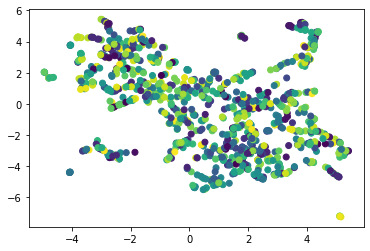

In [105]:
umap_embedding = umap(COUNT=1000)

In [111]:
def pseudo_labels(COUNT=1000, num_clusters=5):
    features_kmeans = np.array(all_features[:COUNT])
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(features_kmeans)
    psuedo_labels = kmeans.predict(features_kmeans)
    plot_scatter_simple(umap_embedding[:COUNT], psuedo_labels[:COUNT])
    return psuedo_labels

array([1, 1, 2, 0, 2, 0, 3, 1, 3, 2, 2, 3, 2, 2, 0, 2, 2, 4, 2, 0, 2, 3,
       0, 4, 2, 4, 4, 3, 2, 0, 2, 2, 2, 0, 0, 3, 2, 1, 1, 2, 0, 4, 2, 3,
       1, 2, 2, 3, 0, 3, 0, 2, 0, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 4, 0, 0,
       0, 0, 2, 0, 2, 2, 3, 0, 2, 3, 2, 4, 2, 3, 2, 3, 2, 3, 2, 4, 2, 2,
       2, 0, 4, 0, 0, 1, 2, 1, 0, 4, 3, 2, 2, 1, 0, 3, 0, 0, 0, 1, 0, 2,
       1, 1, 2, 0, 3, 0, 0, 2, 1, 0, 2, 0, 4, 2, 2, 0, 2, 0, 0, 2, 2, 0,
       2, 0, 4, 2, 4, 2, 2, 3, 3, 0, 0, 0, 4, 4, 2, 0, 3, 3, 2, 4, 3, 4,
       3, 0, 3, 3, 1, 3, 4, 3, 0, 4, 0, 0, 1, 3, 3, 3, 3, 3, 2, 0, 2, 3,
       3, 0, 3, 4, 2, 3, 2, 3, 3, 2, 3, 0, 3, 0, 2, 0, 4, 3, 3, 1, 3, 0,
       3, 2, 2, 3, 2, 2, 4, 2, 3, 3, 2, 0, 2, 1, 4, 2, 3, 3, 0, 3, 0, 0,
       2, 3, 2, 1, 3, 0, 2, 3, 4, 1, 0, 2, 0, 0, 2, 3, 2, 2, 0, 4, 4, 1,
       2, 1, 2, 2, 2, 4, 4, 2, 0, 4, 4, 2, 2, 0, 3, 3, 4, 2, 3, 0, 2, 2,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 3, 2, 2, 0, 0, 2, 3, 4, 0, 3, 0,
       2, 4, 2, 1, 3, 0, 3, 2, 4, 2, 2, 3, 3, 2, 0,

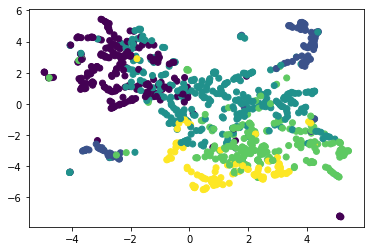

In [112]:
pseudo_labels(COUNT=1000, num_clusters=5)